# PM 2.5 Concentration prediction in next hour with H2O

In [19]:
import time

import h2o
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from h2o import H2OFrame
from h2o.estimators import H2OXGBoostEstimator, H2ODeepLearningEstimator, H2ORandomForestEstimator
from sklearn import preprocessing
from pandas import DataFrame

## Read data from the data.csv file

In [2]:
data = pd.read_csv("../data/data.csv")
data.dtypes

TVOC     float64
TEMP     float64
HUM      float64
PM01     float64
CO2      float64
NH3      float64
LIGHT    float64
AQI      float64
PM25     float64
PM10     float64
CO       float64
O3       float64
SO2      float64
time      object
dtype: object

## Preview 10 samples

In [3]:
data.head(10)

TVOC  TEMP   HUM  PM01    CO2  NH3  LIGHT   AQI  PM25  PM10   CO    O3  \
0  77.0  27.7  72.9  14.0  909.0  5.1    0.0  61.3  61.3  15.7  0.0  18.5   
1  67.0  27.7  73.2  14.0  845.0  4.9    0.0  61.3  61.3  15.7  0.0  18.5   
2  67.0  27.7  73.1  14.0  845.0  5.1    0.0  61.3  61.3  15.7  0.0  18.5   
3  66.0  27.7  73.1  14.0  835.0  5.2    0.0  61.3  61.3  15.7  0.0  18.5   
4  57.0  27.7  73.3  14.0  777.5  4.9    0.0  61.3  61.3  15.7  0.0  18.5   
5  52.5  27.7  73.4  14.0  748.0  4.9    0.0  61.3  61.3  15.7  0.0  19.4   
6  47.0  27.7  73.4  14.0  712.0  5.4    0.0  61.3  61.3  15.7  0.0  18.5   
7  47.0  27.7  73.5  14.0  712.0  5.2    0.0  61.3  61.3  15.7  0.0  18.9   
8  44.0  27.7  73.6  14.0  691.0  5.2    0.0  61.3  61.3  15.7  0.0  19.4   
9  41.5  27.7  73.7  14.0  678.5  4.7    0.0  61.3  61.3  15.7  0.0  18.5   

   SO2                 time  
0  7.1  2019-05-31 17:00:00  
1  7.1  2019-05-31 17:10:00  
2  7.1  2019-05-31 17:20:00  
3  7.1  2019-05-31 17:30:00  
4  7.1  2019-05-31 17:40:00  
5  7.1  2019-05-31 17:50:00  
6  7.1  2019-05-31 18:00:00  
7  7.1  2019-05-31 18:10:00  
8  7.1  2019-05-31 18:20:00  
9  7.1  2019-05-31 18:30:00

## Remove NaN and outliers

In [4]:
date_time = pd.to_datetime(data['time'])
data['time'] = date_time
data = data.dropna(axis=0)
data = data.drop(['SO2', 'CO', 'NH3', 'O3', 'AQI', 'PM01', 'TVOC'], axis=1)
data = data.drop(data[data.LIGHT >= 1000].index)

data.describe()

TEMP           HUM           CO2         LIGHT          PM25  \
count  15594.000000  15594.000000  15594.000000  15594.000000  15594.000000   
mean      28.371752     60.874856   1249.957118     25.940779     47.809613   
min       20.700000     35.900000    400.000000      0.000000      0.000000   
25%       27.600000     55.900000    541.000000      0.000000     33.300000   
50%       28.600000     61.200000    755.000000      2.000000     50.000000   
75%       29.400000     67.000000   1224.000000     15.000000     61.300000   
max       33.100000     77.400000   7992.000000    315.000000    121.900000   
std        1.879867      7.735902   1451.796138     63.715778     19.953644   

               PM10                           time  
count  15594.000000                          15594  
mean      12.315814  2019-09-13 02:30:38.137745152  
min        0.000000            2019-05-31 17:00:00  
25%        7.400000            2019-08-18 01:22:30  
50%       12.000000            2019-09-20 21:35:00  
75%       15.700000            2019-10-18 02:27:30  
max       48.100000            2019-11-14 07:40:00  
std        6.457094                            NaN

## Generate features and labels
- List of all features:
    - **f0 - f1**: Season bins
    - **f2**: Month
    - **f3**: Weekend
    - **f4**: Hour
    - **f5**: Current PM25 AQI value
    - **f6**: Current CO2 concentration
    - **f7**: Current temperature
    - **f8**: Current humidity
    - **f9**: Current illuminance
    - **f10 → f34**: PM25 AQI value from 1 to 24 hour ago
    - **f35**: maximum PM25 AQI value in last 24 hours
    - **f36**: minimum PM25 AQI value in last 24 hours
    - **f37**: average PM25 AQI value in last 24 hours
    - **f38**: maximum temperature in last 24 hours
    - **f39**: minimum temperature in last 24 hours
    - **f40**: average temperature in last 24 hours
    - **f41**: maximum humidity in last 24 hours
    - **f42**: minimum humidity in last 24 hours
    - **f43**: average humidity in last 24 hours
- Label: Next PM25 AQI value


### Create <i>Month</i>, <i>Day of week</i>, <i>Hour</i> features from time column.

In [5]:
time_idx = pd.DatetimeIndex(data.time)
data = data.groupby([time_idx.month, time_idx.day, time_idx.dayofweek, time_idx.hour]).mean(numeric_only=True)
data.index.names = ["Month", "Day", "Weekend", "Hour"]
data.index = data.index.droplevel(1)
data.head(20)

TEMP        HUM          CO2       LIGHT  PM25  PM10
Month Weekend Hour                                                           
5     4       17    27.700000  73.166667   826.583333    0.000000  61.3  15.7
              18    27.700000  73.666667   687.416667    0.000000  61.3  15.7
              19    27.650000  74.283333   594.333333    0.000000  61.3  15.7
              20    27.600000  74.750000   508.916667    0.000000  61.3  15.7
              21    27.550000  75.100000   430.250000    0.000000  61.3  15.7
              22    27.516667  75.250000   403.500000    0.166667  61.3  15.7
              23    27.533333  75.033333   407.250000    2.666667  61.3  15.7
6     5       0     27.566667  74.850000   409.166667    7.333333  61.3  15.7
              1     27.600000  74.483333   406.500000   13.166667  61.3  15.7
              2     27.816667  72.166667   434.666667   38.500000  61.3  15.7
              3     28.083333  70.150000   590.333333   34.750000  61.3  15.7
              4     28.250000  69.216667   685.383333   37.833333  61.3  15.7
              5     28.216667  68.550000   758.333333   33.550000  61.3  15.7
              6     28.283333  66.950000   795.500000   34.466667  61.3  15.7
              7     28.166667  65.783333   864.833333   17.083333  61.3  15.7
              8     27.900000  63.083333   918.050000   15.166667  61.3  15.7
              9     27.533333  67.416667  1049.000000    7.716667  61.3  15.7
              10    27.866667  66.083333  1098.666667  141.916667  61.3  15.7
              11    27.800000  66.933333  1106.550000  183.500000  61.3  15.7
              12    26.783333  61.700000   906.166667    0.000000  61.3  15.7

### Generate f10 → f34 features

In [6]:
PM25_cols = []
TEMP_cols = []
HUM_cols = []

for i in range(1, 25):
    col = 'PM25P' + str(i)
    PM25_cols.append(col)
    data[col] = data['PM25'].shift(periods=i)

    col = 'TEMPP' + str(i)
    TEMP_cols.append(col)
    data[col] = data['TEMP'].shift(periods=i)

    col = 'HUMP' + str(i)
    HUM_cols.append(col)
    data[col] = data['HUM'].shift(periods=i)

data["MAXPM25"] = data[PM25_cols].max(axis=1)
data["MINPM25"] = data[PM25_cols].min(axis=1)
data["AVGPM25"] = data[PM25_cols].mean(axis=1)

data["MAXTEMP"] = data[TEMP_cols].max(axis=1)
data["MINTEMP"] = data[TEMP_cols].min(axis=1)
data["AVGTEMP"] = data[TEMP_cols].mean(axis=1)

data["MAXHUM"] = data[HUM_cols].max(axis=1)
data["MINHUM"] = data[HUM_cols].min(axis=1)
data["AVGHUM"] = data[HUM_cols].mean(axis=1)

data = data.drop(TEMP_cols, axis=1)
data = data.drop(HUM_cols, axis=1)

### Generate labels

In [7]:
data['Label'] = data['PM25'].shift(periods=-1)
data.head(25)

TEMP        HUM          CO2       LIGHT  PM25  PM10  \
Month Weekend Hour                                                              
5     4       17    27.700000  73.166667   826.583333    0.000000  61.3  15.7   
              18    27.700000  73.666667   687.416667    0.000000  61.3  15.7   
              19    27.650000  74.283333   594.333333    0.000000  61.3  15.7   
              20    27.600000  74.750000   508.916667    0.000000  61.3  15.7   
              21    27.550000  75.100000   430.250000    0.000000  61.3  15.7   
              22    27.516667  75.250000   403.500000    0.166667  61.3  15.7   
              23    27.533333  75.033333   407.250000    2.666667  61.3  15.7   
6     5       0     27.566667  74.850000   409.166667    7.333333  61.3  15.7   
              1     27.600000  74.483333   406.500000   13.166667  61.3  15.7   
              2     27.816667  72.166667   434.666667   38.500000  61.3  15.7   
              3     28.083333  70.150000   590.333333   34.750000  61.3  15.7   
              4     28.250000  69.216667   685.383333   37.833333  61.3  15.7   
              5     28.216667  68.550000   758.333333   33.550000  61.3  15.7   
              6     28.283333  66.950000   795.500000   34.466667  61.3  15.7   
              7     28.166667  65.783333   864.833333   17.083333  61.3  15.7   
              8     27.900000  63.083333   918.050000   15.166667  61.3  15.7   
              9     27.533333  67.416667  1049.000000    7.716667  61.3  15.7   
              10    27.866667  66.083333  1098.666667  141.916667  61.3  15.7   
              11    27.800000  66.933333  1106.550000  183.500000  61.3  15.7   
              12    26.783333  61.700000   906.166667    0.000000  61.3  15.7   
              13    26.983333  65.650000   961.500000    0.000000  61.3  15.7   
              14    26.950000  67.416667   917.916667    0.000000  61.3  15.7   
              15    27.116667  69.216667   941.333333    0.000000  61.3  15.7   
              16    27.233333  70.716667   941.333333    0.000000  61.3  15.7   
              17    27.300000  71.733333   871.083333    0.000000  61.3  15.7   

                    PM25P1  PM25P2  PM25P3  PM25P4  ...  MAXPM25  MINPM25  \
Month Weekend Hour                                  ...                     
5     4       17       NaN     NaN     NaN     NaN  ...      NaN      NaN   
              18      61.3     NaN     NaN     NaN  ...     61.3     61.3   
              19      61.3    61.3     NaN     NaN  ...     61.3     61.3   
              20      61.3    61.3    61.3     NaN  ...     61.3     61.3   
              21      61.3    61.3    61.3    61.3  ...     61.3     61.3   
              22      61.3    61.3    61.3    61.3  ...     61.3     61.3   
              23      61.3    61.3    61.3    61.3  ...     61.3     61.3   
6     5       0       61.3    61.3    61.3    61.3  ...     61.3     61.3   
              1       61.3    61.3    61.3    61.3  ...     61.3     61.3   
              2       61.3    61.3    61.3    61.3  ...     61.3     61.3   
              3       61.3    61.3    61.3    61.3  ...     61.3     61.3   
              4       61.3    61.3    61.3    61.3  ...     61.3     61.3   
              5       61.3    61.3    61.3    61.3  ...     61.3     61.3   
              6       61.3    61.3    61.3    61.3  ...     61.3     61.3   
              7       61.3    61.3    61.3    61.3  ...     61.3     61.3   
              8       61.3    61.3    61.3    61.3  ...     61.3     61.3   
              9       61.3    61.3    61.3    61.3  ...     61.3     61.3   
              10      61.3    61.3    61.3    61.3  ...     61.3     61.3   
              11      61.3    61.3    61.3    61.3  ...     61.3     61.3   
              12      61.3    61.3    61.3    61.3  ...     61.3     61.3   
              13      61.3    61.3    61.3    61.3  ...     61.3     61.3   
              14      61.3    61.3    61.3    61.3  ...     61.3  

### Remove rows containing NaN values and add season feature columns

In [8]:
data = data.dropna(axis=0)
columns = data.index.names
columns = np.append(columns, data.columns.values[:-1])
date_time_values = np.asmatrix([list(item) for item in data.index.values])
data = np.append(date_time_values, data.to_numpy(), axis=1)
data[:, 1] = np.where(data[:, 1] < 5, 0, 1)

bin_season = np.where(data[:, 0] <= 3, [0, 0], np.where(data[:, 0] <= 6, [0, 1], np.where(data[:, 0] <= 9, [1, 0],
                                                                                          np.where(data[:, 0] <= 12,
                                                                                                   [1, 1], 0))))
# data = np.delete(data, 0, 1)
data = np.append(bin_season, data, axis=1)
columns = ["SS_BIN_1", "SS_BIN_2"] + columns.tolist() + ["Label"]
data


matrix([[ 0.        ,  1.        ,  6.        , ..., 61.7       ,
         70.06736111, 61.3       ],
        [ 0.        ,  1.        ,  6.        , ..., 61.7       ,
         70.00763889, 61.3       ],
        [ 0.        ,  1.        ,  6.        , ..., 61.7       ,
         69.93263889, 61.3       ],
        ...,
        [ 1.        ,  1.        , 11.        , ..., 65.1       ,
         67.87986111, 23.6       ],
        [ 1.        ,  1.        , 11.        , ..., 62.85      ,
         67.50208333, 25.35      ],
        [ 1.        ,  1.        , 11.        , ..., 62.85      ,
         67.15416667, 23.32      ]])

## Save processed data to a file

In [9]:
np.savetxt("../processed_data/processed_data.csv", data, delimiter=",")

## Initialize a H2O context, connect to the H2O server, and upload the processed data file to the H2O server

In [10]:
h2o.init(ip="192.168.159.128", port=54321)

df = h2o.upload_file("../processed_data/processed_data.csv", col_names=columns)
df.show()

Checking whether there is an H2O instance running at http://192.168.159.128:54321. connected.


--------------------------  ----------------------------
H2O_cluster_uptime:         14 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.44.0.1
H2O_cluster_version_age:    15 days
H2O_cluster_name:           local
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    1.438 Gb
H2O_cluster_total_cores:    4
H2O_cluster_allowed_cores:  4
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://192.168.159.128:54321
H2O_connection_proxy:       null
H2O_internal_security:      False
Python_version:             3.11.4 final
--------------------------  ----------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


SS_BIN_1    SS_BIN_2    Month    Weekend    Hour     TEMP      HUM      CO2      LIGHT    PM25    PM10    PM25P1    PM25P2    PM25P3    PM25P4    PM25P5    PM25P6    PM25P7    PM25P8    PM25P9    PM25P10    PM25P11    PM25P12    PM25P13    PM25P14    PM25P15    PM25P16    PM25P17    PM25P18    PM25P19    PM25P20    PM25P21    PM25P22    PM25P23    PM25P24    MAXPM25    MINPM25    AVGPM25    MAXTEMP    MINTEMP    AVGTEMP    MAXHUM    MINHUM    AVGHUM    Label
----------  ----------  -------  ---------  ------  -------  -------  -------  ---------  ------  ------  --------  --------  --------  --------  --------  --------  --------  --------  --------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------  --------  --------  --------  -------
         0           1        6          1      17  27.3     71.7333  871.083   0           61.3    15.7      61.3      61.3      61.3      61.3      61.3      61.3      61.3      61.3      61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3    28.2833    26.7833    27.6417   75.25        61.7   70.0674     61.3
         0           1        6          1      18  27.3     71.8667  775.833   0           61.3    15.7      61.3      61.3      61.3      61.3      61.3      61.3      61.3      61.3      61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3    28.2833    26.7833    27.625    75.25        61.7   70.0076     61.3
         0           1        6          1      19  27.3     72.0667  718.167   0           61.3    15.7      61.3      61.3      61.3      61.3      61.3      61.3      61.3      61.3      61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3    28.2833    26.7833    27.6083   75.25        61.7   69.9326     61.3
         0           1        6          1      20  27.25    72.1667  683       0           61.3    15.7      61.3      61.3      61.3      61.3      61.3      61.3      61.3      61.3      61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3    28.2833    26.7833    27.5938   75.25        61.7   69.8403     61.3
         0           1        6          1      21  27.2167  72.3333  653.333   0           61.3    15.7      61.3      61.3      61.3      61.3      61.3      61.3      61.3      61.3      61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3    28.2833    26.7833    27.5792   75.25        61.7   69.7326     61.3
         0           1        6          1      22  27.2     72.55    629.833   0.833333    61.3    15.7      61.3      61.3      61.3      61.3      61.3      61.3      61.3      61.3      61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3    28.2833    26.7833    27.5653   75.25        61.7   69.6174     61.3
         0           1        6          1      23  27.2667  72.6     625.667   4.83333     61.3    15.7      61.3      61.3      61.3      61.3      61.3      61.3      61.3      61.3      61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3       61.3

## Split the data frame into a train set (80%) and a valid set (20%) randomly

In [11]:
predictors = df.columns
response = "Label"

train, valid = df.split_frame(ratios=[.8], seed=1234)

## Call to the H2O server to train a XGBoost model

In [12]:
xgb = H2OXGBoostEstimator(booster='dart', normalize_type="tree", ntrees=100, max_depth=10, learn_rate=0.15, seed=1234)
start_time = time.time_ns()
xgb.train(x=predictors, y=response, training_frame=train)
end_time = time.time_ns()

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%


In [13]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = [16, 10]

## Evaluate the model performance and display the correlation between actual values and predicted values

ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.024602925882336705
RMSE: 0.1568531985084675
MAE: 0.10680806870777249
RMSLE: 0.005633481404092775
Mean Residual Deviance: 0.024602925882336705
R-squared: 0.9999371393681212
Training time: 4695.4225 ms
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


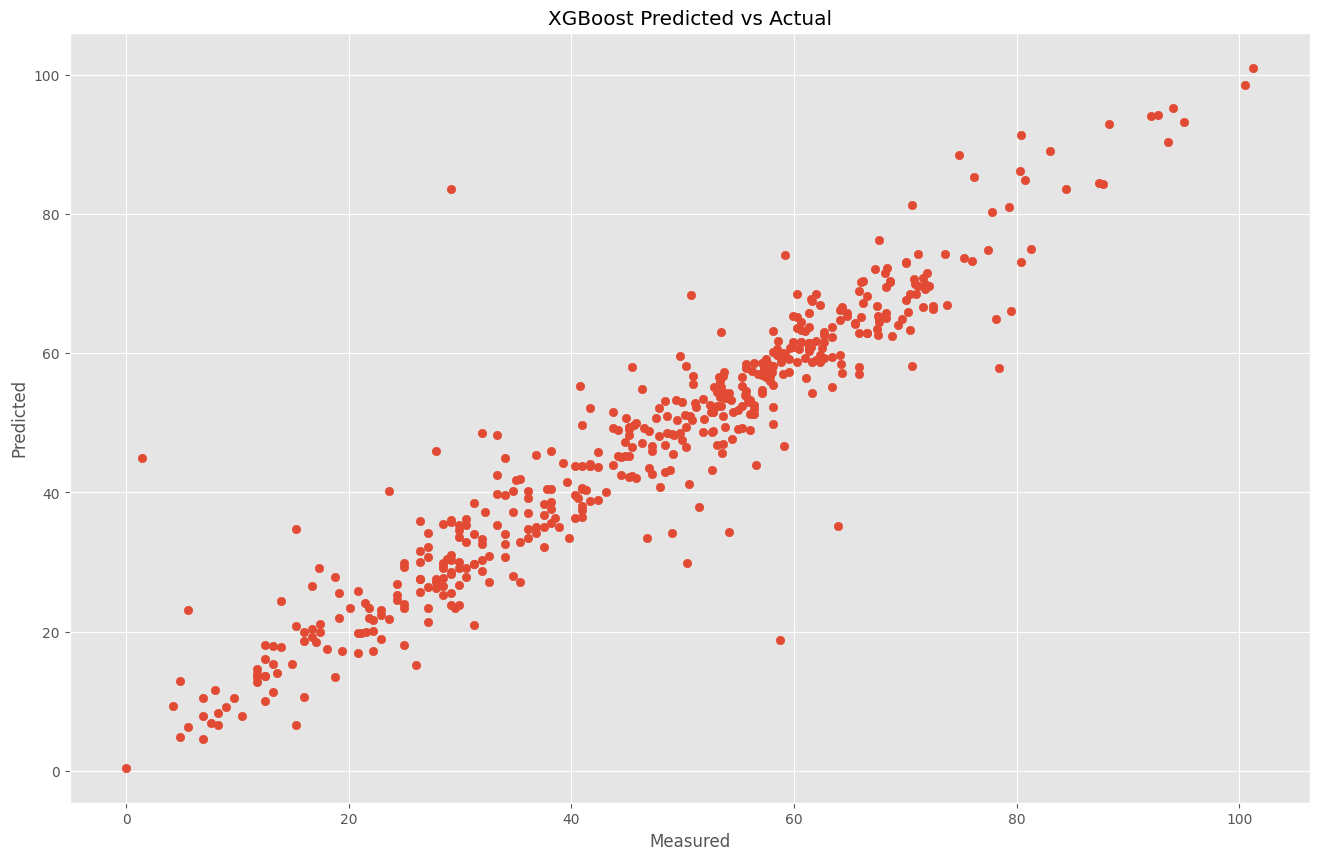

In [14]:
perf = xgb.model_performance()
print(perf)
print(f"R-squared: {xgb.r2()}")
print(f"Training time: {(end_time - start_time) / 10 ** 6} ms")

# Generate predictions on a test set (if necessary):
pred = xgb.predict(valid)
pred = h2o.as_list(pred).values.tolist()
actual_vals = valid[-1].as_data_frame().values.tolist()

plt.scatter(actual_vals, pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('XGBoost Predicted vs Actual')
plt.show()

## Call to the H2O server to train a MLP model

In [15]:
dl = H2ODeepLearningEstimator(hidden=[128, 64, 32],
                              mini_batch_size=256,
                              epochs=1000,
                              train_samples_per_iteration=-1,
                              reproducible=True,
                              activation="Tanh",
                              single_node_mode=False,
                              balance_classes=False,
                              force_load_balance=False,
                              adaptive_rate=False,
                              nesterov_accelerated_gradient=True,
                              momentum_start=0.05,
                              seed=23123,
                              tweedie_power=1.5,
                              score_training_samples=0,
                              score_validation_samples=0,
                              stopping_rounds=0)
start_time = time.time_ns()
dl.train(x=predictors, y=response, training_frame=train)
end_time = time.time_ns()

deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%


## Evaluate the model performance and display the correlation between actual values and predicted values

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.05261359743791197
RMSE: 0.22937654073141822
MAE: 0.1353292822638649
RMSLE: 0.008071235734734138
Mean Residual Deviance: 0.05261359743791197
R-squared: 0.9998655719244054
Training time: 316947.5625 ms
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


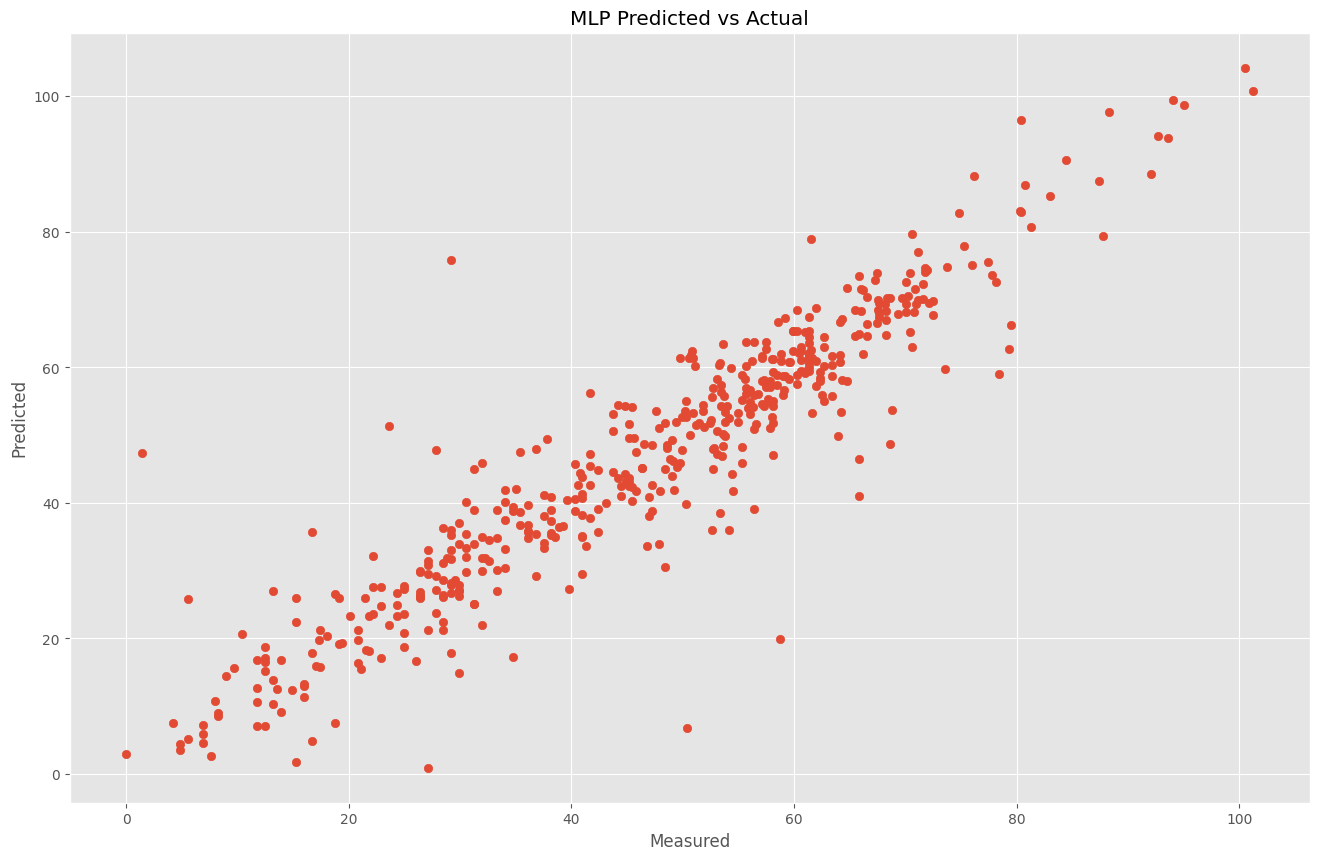

In [16]:
perf = dl.model_performance()
print(perf)
print(f"R-squared: {dl.r2()}")
print(f"Training time: {(end_time - start_time) / 10 ** 6} ms")

pred = dl.predict(valid)
pred = h2o.as_list(pred).values.tolist()

plt.scatter(actual_vals, pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('MLP Predicted vs Actual')
plt.show()

## Call to the H2O server to train a Random Forest model

In [17]:
train_scaler = preprocessing.StandardScaler()
new_train = h2o.deep_copy(train, 'new_train')
std_train = train_scaler.fit_transform(h2o.as_list(new_train))
std_train_df = H2OFrame(DataFrame(data=std_train, columns=new_train.columns))

valid_scaler = preprocessing.StandardScaler()
new_valid = h2o.deep_copy(valid, 'new_valid')
std_valid = valid_scaler.fit_transform(h2o.as_list(new_valid))
std_valid_df = H2OFrame(DataFrame(data=std_valid, columns=new_train.columns))

drf = H2ORandomForestEstimator(ntrees=200, max_depth=10, seed=1234)
start_time = time.time_ns()
drf.train(x=predictors, y=response, training_frame=std_train_df)
end_time = time.time_ns()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


## Evaluate the model performance and display the correlation between actual values and predicted values

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.0872716131899519
RMSE: 0.29541769275036983
MAE: 0.1870747551671335
RMSLE: NaN
Mean Residual Deviance: 0.0872716131899519
R-squared: 0.9127283863822323
Training time: 3782.4091 ms
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


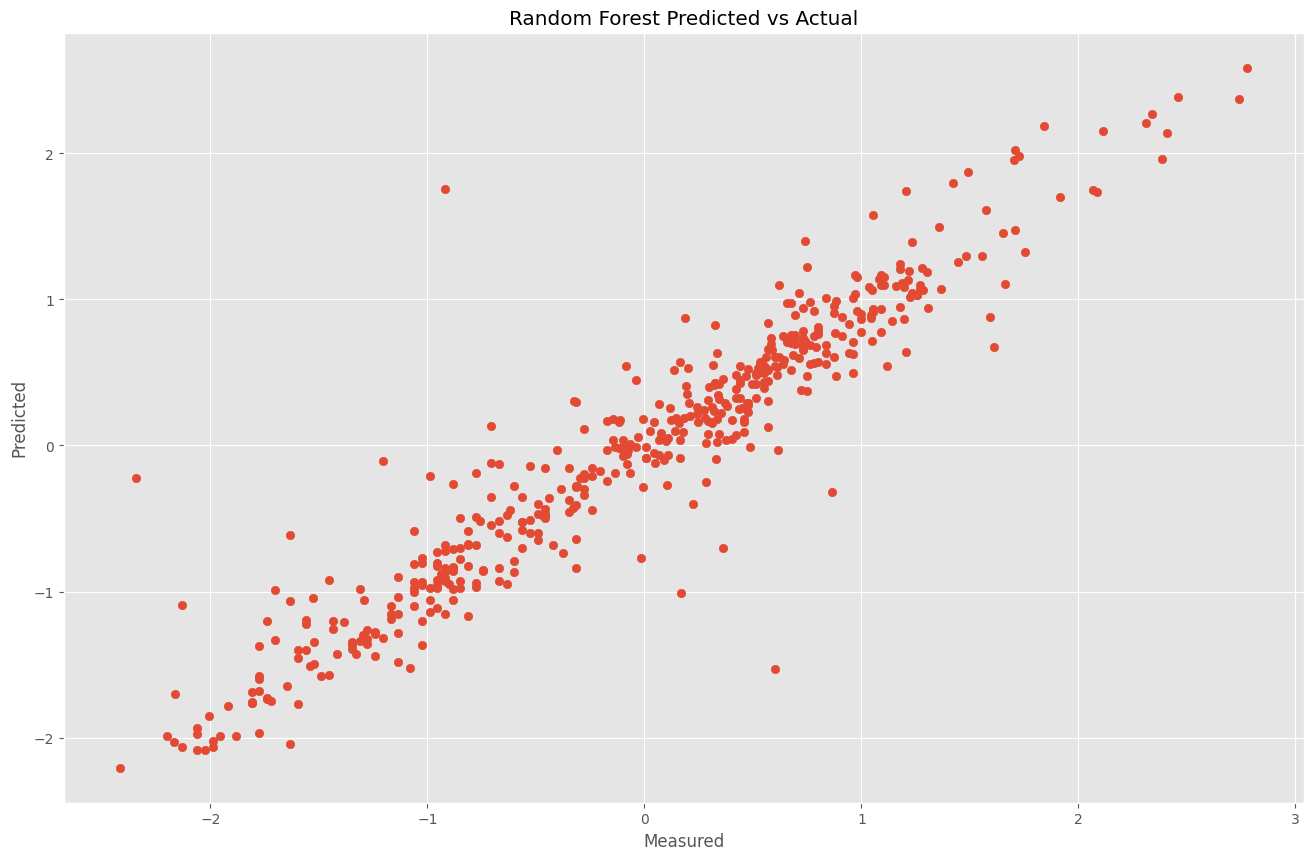

In [18]:
perf = drf.model_performance()
print(perf)
print(f"R-squared: {drf.r2()}")
print(f"Training time: {(end_time - start_time) / 10 ** 6} ms")

pred = drf.predict(std_valid_df)
pred = h2o.as_list(pred).values.tolist()
actual_vals = std_valid_df[-1].as_data_frame().values.tolist()

plt.scatter(actual_vals, pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Random Forest Predicted vs Actual')
plt.show()
